In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
import numpy as np
import pandas as pd
import time, sys, subprocess, os
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.core.display import display, HTML
from IPython.display import clear_output

In [20]:
def ternary_plot(data,
                 title = '',
                 labels = ('R', 'P', 'S'),
                 sides = 3,
                 start_angle = 90,
                 fig_args = {'figsize':(18,18),'facecolor':'white','edgecolor':'white'},
                 edge_args = {'color':'black','linewidth':2},
                 line_color = (0, 0, 0),
                 rotate_labels = False,
                 label_offset = 0.10,
                 scaling = False,
                 show = True
):
    
    basis = np.array([
        [
            np.cos(2*x*np.pi/sides + start_angle*np.pi/180),
            np.sin(2*x*np.pi/sides + start_angle*np.pi/180)
        ] for x in range(sides)
    ])
    
    if scaling:# If data is Nxsides, newdata is Nx2.
        newdata = np.dot(data.div(data.sum(axis=1), axis=0),basis)# Scales data for you.
    else:
        newdata = np.dot(data,basis)# Assumes data already sums to 1.
    
    if  not show:
        return newdata
        
    fig = plt.figure(**fig_args)
    ax = fig.add_subplot(111)
    ax.text(-0.5, 0.3, title, rotation=60, horizontalalignment='center', verticalalignment='center', size=34)
    
    for i,l in enumerate(labels):
        if i >= sides:
            break
        
        x = basis[i,0]
        y = basis[i,1]
        if rotate_labels:
            angle = 180 * np.arctan(y/x)/np.pi + 90
            if angle > 90 and angle <= 270:
                angle = np.mod(angle + 180, 360)
        else:
            angle = 0
        
        ax.text(
            x * (1 + label_offset),
            y * (1 + label_offset),
            l,
            horizontalalignment='center',
            verticalalignment='center',
            rotation=angle,
            size=34
        )
        
    # clear normal axes
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_frame_on(False)
    
    # plot border
    ax.plot(
        [ basis[x,0] for x in list(range(sides)) + [0,] ],
        [ basis[x,1] for x in list(range(sides)) + [0,] ],
        **edge_args
    )
    
    # extra room for labels
    ax.set_xlim(left=-1.2, right=1.2)
    ax.set_ylim(bottom=-1.2, top=1.2)
    
    # plot
    end = len(newdata[:,0]) - 1
    for i in range(0,end):
        ax.plot(newdata[:,0][i:i+2], newdata[:,1][i:i+2], '.-', linewidth=2, alpha=0.99, c=(0, i / end, i / end))
    # ax.plot(newdata[:,0], newdata[:,1], linewidth=2, alpha=0.99, c='#00ff00')
    
    # fig.show()

In [12]:
def plot_df(df,
              start=0,
              end=-1, # if end < start, take everything from start upwards
              sep=',',
              size=(18,5),
              title='Average Genome',
              headers=['Avg Rock Genome','Avg Paper Genome','Avg Scissor Genome'],
              colors=['grey', 'green', 'orange'],
              line_width=2,
              scaling=False,
              plot_cartesian=False):
    if end < start:
        end = len(df)
    
    if start > 0 or end < len(df):
        df = df[start:end]
    
    ternary_plot(df[headers], scaling=scaling, title=title)
    
    if plot_cartesian:
        plt.figure(figsize=size)
        for i in range(0, len(headers)):
            plt.plot(df['Generation'], df[headers[i]], color=colors[i], linewidth=line_width, label=headers[i])

        plt.xlabel('Generation')
        plt.ylabel('Probability')
        plt.title(title)
        plt.legend()
        plt.show()

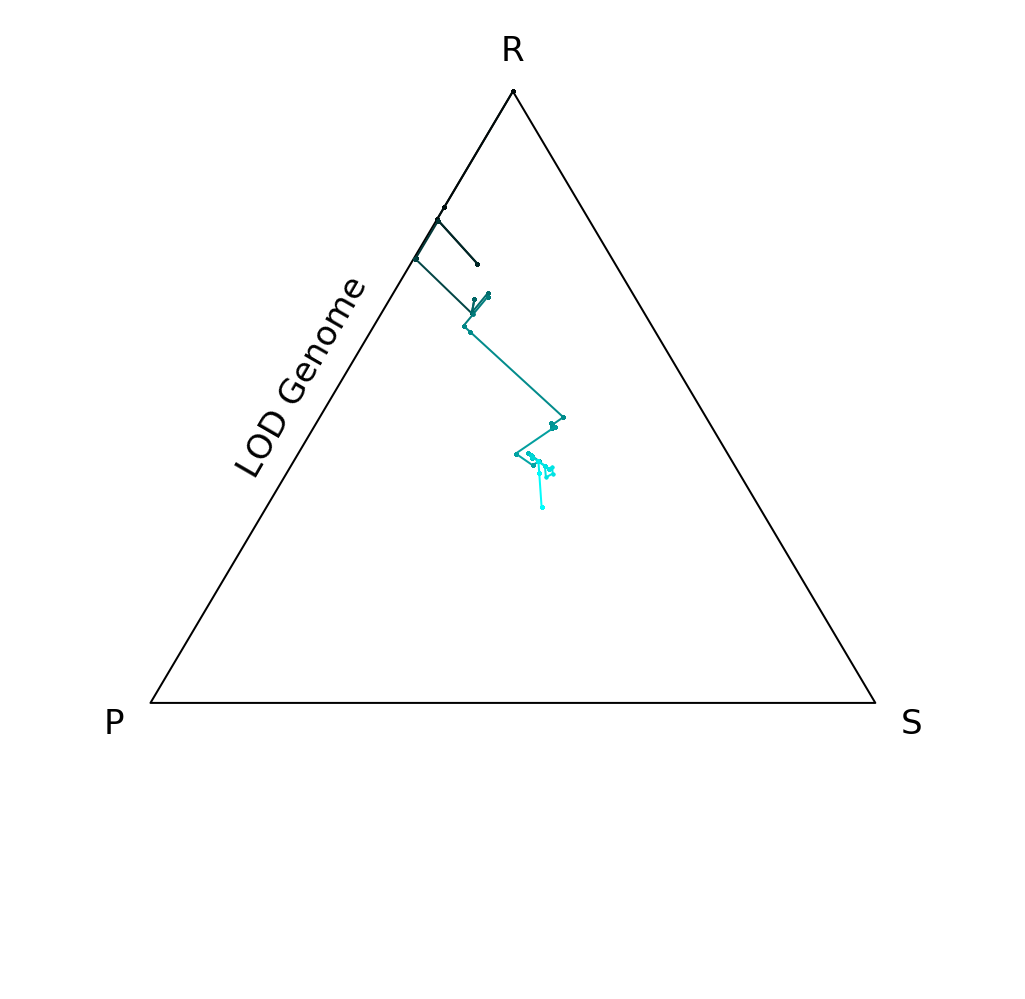

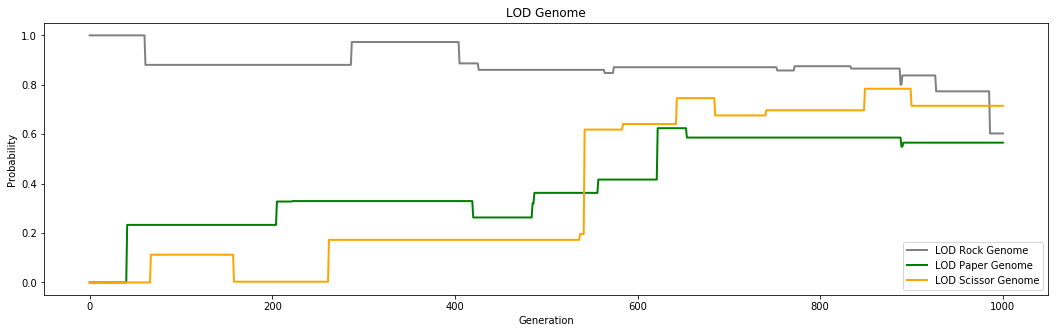

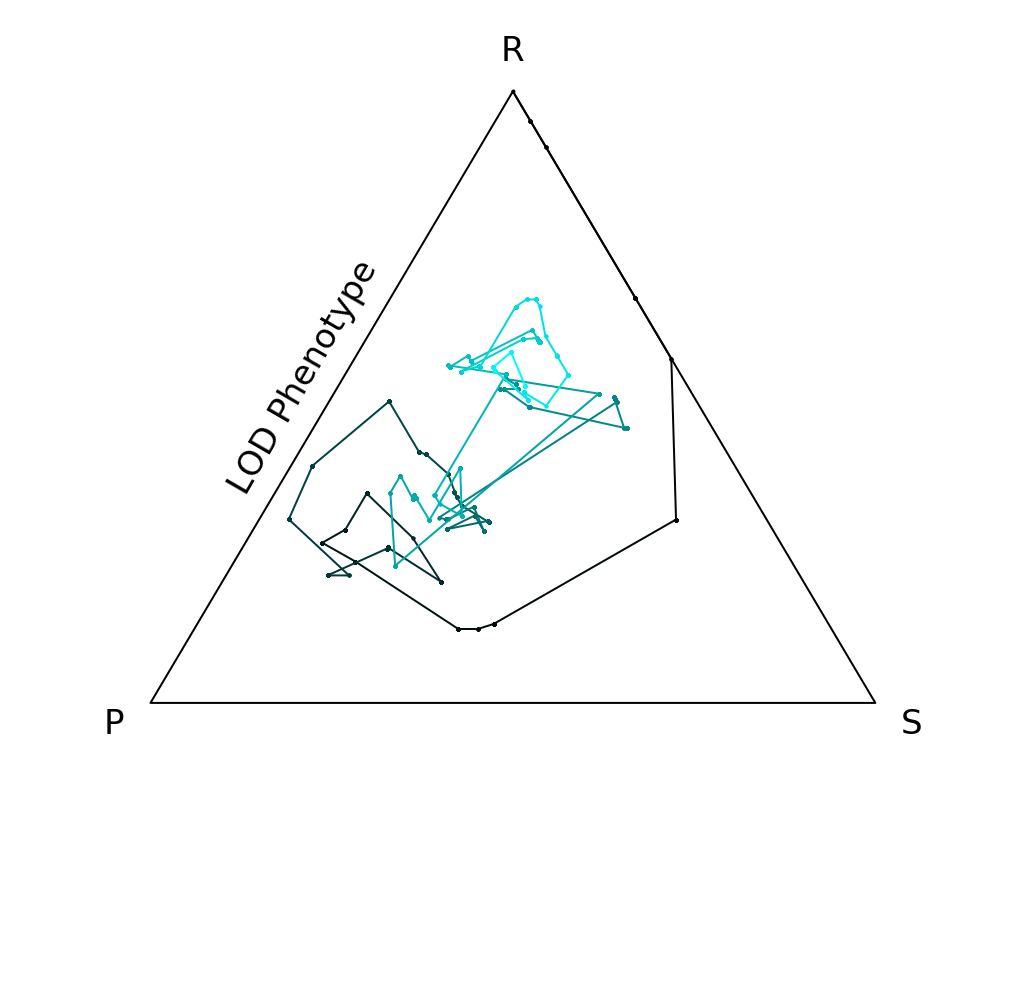

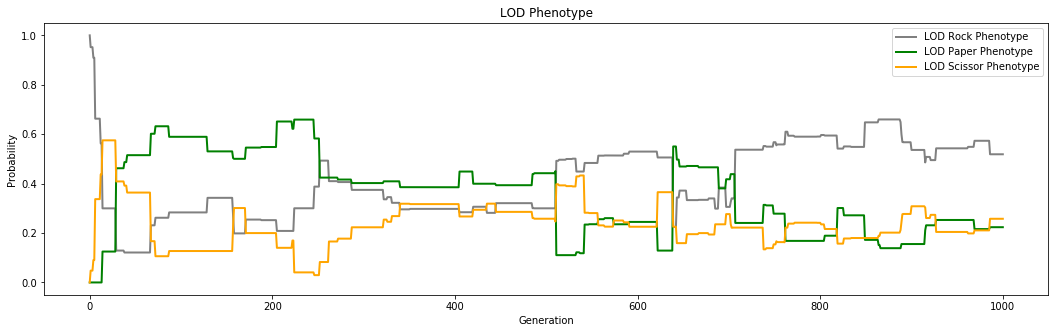

In [26]:
df = pd.read_csv('csvs/1000,16,1000 (0,-1,1)(1,0,-1)(-1,1,0) avg.csv', sep=',')

titles = [
    # 'Average Genome', 'Average Phenotype',
    'LOD Genome', 'LOD Phenotype'
]
headers = [
    # ["Avg Rock Genome", "Avg Paper Genome", "Avg Scissor Genome"],
    # ["Avg Rock Phenotype", "Avg Paper Phenotype", "Avg Scissor Phenotype"],
    ["LOD Rock Genome", "LOD Paper Genome", "LOD Scissor Genome"],
    ["LOD Rock Phenotype", "LOD Paper Phenotype", "LOD Scissor Phenotype"]
]

scaling = True
for x in range(0, len(titles)):
    plot_df(df, scaling=scaling, title=titles[x], headers=headers[x], plot_cartesian=True)

In [93]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

def simulate_generations(args: dict = {}):
    arguments = {
        '--agents':         '1000',
        '--opponents':      '16',
        '--generations':    '200000',
        '--winners':        '100',
        '--genomestart':    '"{}"',
        '--matrixstart':    '1,0,0/0,1,0/0,0,1',
        '--probabilities':  '0.01,0.01,0.01',
        '--matrixmutation': '0.001',
        '--payoff':         '0,-1,1/1,0,-1/-1,1,0',
        '--file':           None,
        '--separator':      ',',
        '--verbose':        '1'
    }
    
    for key, value in args.items():
        arguments[key] = value
    
    arguments['--outstart'] = 'now at '
    arguments['--outend'] = '\\\\n'
    
    # generate file name. Counts up if file already exists
    if arguments['--file'] is None:
        filename = '/Users/felixfritz/Desktop/AgentEvolution/results/csvs/{},{},{},{}'.format(
            datetime.now().strftime('%Y-%m-%d %H:%M'),
            arguments['--agents'],
            arguments['--opponents'],
            arguments['--generations'])
        
        tmp_filename = filename
        counter = 0
        while os.path.isfile(tmp_filename + '.csv'):
            counter += 1
            tmp_filename = filename + ' ' + str(counter)
        
        arguments['--file'] = tmp_filename + '.csv'
    
    # create command to be executed
    command = ['../bin/agentevolver']
    
    boolflags = ['--verbose', '--help', '-h']
    for key, value in arguments.items():
        if key not in boolflags:
            command.extend((key, value))
        elif value == '1' or value == 'true' or value == 'yes':
            command.append(key)
    
    command_str = subprocess.list2cmdline(command)
    
    # process = subprocess.Popen(command_str, shell=True, stdout=subprocess.PIPE)
    process = subprocess.Popen(command_str, shell=True, stdout=subprocess.PIPE)
    for line in iter(process.stdout.readline, b''):
        print(line.decode('utf-8').replace('\n', ''))
    
    process.wait()

In [95]:
simulate_generations({'-h': '1'})

parsing input
Arguments gotten
../bin/agentevolver
--agents
1000
--opponents
16
--generations
200000
--winners
100
--genomestart
"{}"
--matrixstart
1,0,0/0,1,0/0,0,1
--probabilities
0.01,0.01,0.01
--matrixmutation
0.001
--payoff
0,-1,1/1,0,-1/-1,1,0
--file
/Users/felixfritz/Desktop/AgentEvolution/results/csvs/2019-04-15 23:14,1000,16,200000.csv
--separator
,
--verbose
-h
--outstart
now at 
--outend
\n
 - simulate agent based games over multiple generations
Usage:
  ../bin/agentevolver [OPTION...]

  -a, --agents arg          number of agents for each generation (default
                            1000)
  -o, --opponents arg       number of opponents each agent plays against
                            (default 500)
  -g, --generations arg     number of generations to simulate (default 1000)
  -w, --winners arg         number of agents that are allowed to make
                            offsprings after each generation (default 100)
  -s, --genomestart arg     values that genome shoul

In [5]:
import shellcommands

shellcommands.simulate_generations({'--generations': '2000'})

Progress: [####################] 100.0%

Done
Time elapsed: 00:00:07.626
Closing temporary file: /Users/felixfritz/Desktop/AgentEvolution/results/csvs/2019-04-17 14:16,1000,16,2000.csv.tmp
Opening actual output file: /Users/felixfritz/Desktop/AgentEvolution/results/csvs/2019-04-17 14:16,1000,16,2000.csv
Getting index 0 from population
0x7fa304da8f98
Closing streams for /Users/felixfritz/Desktop/AgentEvolution/results/csvs/2019-04-17 14:16,1000,16,2000.csv.tmp and /Users/felixfritz/Desktop/AgentEvolution/results/csvs/2019-04-17 14:16,1000,16,2000.csv
Deleted temporary file /Users/felixfritz/Desktop/AgentEvolution/results/csvs/2019-04-17 14:16,1000,16,2000.csv.tmp
